In [28]:
!pip install torch
!pip install emoji
!pip install tweet-preprocessor
!pip install transformers accelerate
!pip install scikit-learn

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
import numpy as np
import pandas as pd
import emoji
import re
import preprocessor as p

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

In [30]:
# Read the CSV file.
dataColumns = ['id', 'text', 'label']
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/train_all_tasks.csv', header=0)

dev_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/dev_task_a_entries.csv',
                  header=0)
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masters thesis/test_task_a_entries.csv',
                  header=0)

In [31]:
#train_df_taskA=train_df.drop(['label_vector'], axis=1)
train_df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [32]:
print(f"Unique label test: {len(train_df['label_sexist'].unique()) == 2}")
print(f"not sexist example count: {len(train_df[train_df['label_sexist']=='not sexist']) == 10602}")
print(f"sexist example count: {len(train_df[train_df['label_sexist']=='sexist']) == 3398}")


Unique label test: True
not sexist example count: True
sexist example count: True


In [33]:
def preprocess_text(text: str) -> str:
    """
    Function takes a raw text and performs the following processing steps:
    1. Lower case all text
    2. De-emoji the text
    3. Remove all hashtags, mentions, and urls
    4. Remove all non-alphabet characters except the followng punctuations: period, exclamation mark, and question mark
    """
    text = text.lower()
    text = emoji.demojize(text)
    text = p.clean(text)

    text = re.sub(r'[^a-z.!?]', ' ', text.replace('_','')).strip()

    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    text=re.sub(r'[^\w\s]','',text)
    text=text.replace("[URL]","")
    text=text.replace("[USER]","")
    text=re.sub(r"[â€™ºðŸ‡˜Žµ±¤£‘Œ”œ]","",text)

    return text

train_df["text"] = train_df["text"].apply(preprocess_text)


In [34]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):

    text = remove_between_square_brackets(text)
    return text

In [35]:
train_df['text']=train_df['text'].apply(denoise_text)

{'not sexist': 10602, 'sexist': 3398}


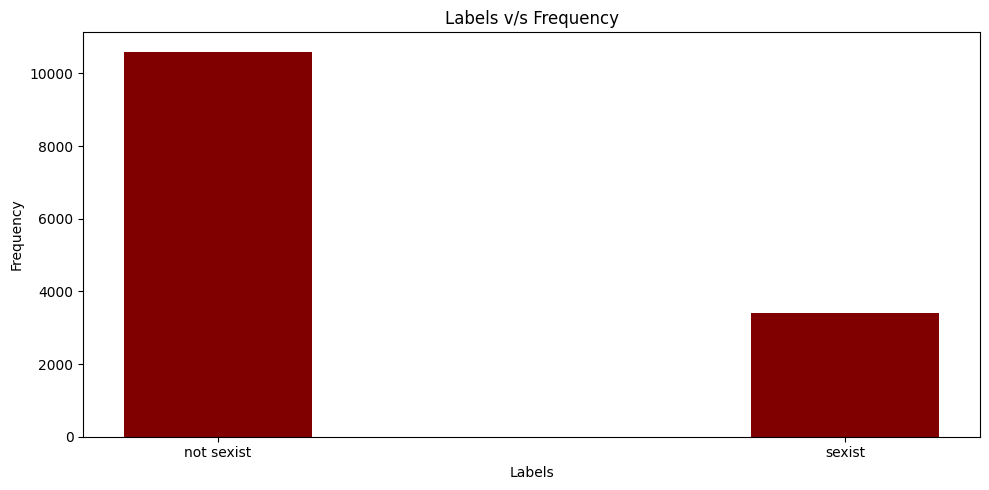

In [36]:
import matplotlib.pyplot as plt

freq=train_df['label_sexist'].value_counts().to_dict()
print(freq)

data = freq
types = list(data.keys())
frequency = list(data.values())

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(types, frequency, color ='maroon',width = 0.3)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels v/s Frequency")
plt.tight_layout()
plt.show()

In [37]:

# using the train_test_split to split the data into training, validation, and
# test datasets
train, val = train_test_split(train_df, test_size = 0.3, random_state = 2023, stratify = train_df.label_sexist)
val, test = train_test_split(val, test_size = 0.5, random_state = 2023, stratify = val.label_sexist)

In [38]:
train["label_sexist"] = train["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
val["label_sexist"] = val["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()
test["label_sexist"] = test["label_sexist"].replace({"not sexist": 0, "sexist": 1}).to_list()

In [39]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments
from transformers import DebertaTokenizer, DebertaModel
import torch

X_train = train["text"].tolist()
y_train = train["label_sexist"].tolist()

X_test = test["text"].tolist()
y_test = test["label_sexist"].tolist()

X_val = val["text"].tolist()
y_val = val["label_sexist"].tolist()

### Binary Ensemble

In [40]:
from sklearn.ensemble import VotingClassifier

# Load the trained ELECTRA model
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
loaded_electra_model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator')
loaded_electra_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Masters thesis/electraModelA.pth'))
loaded_electra_model.eval()

# Load the trained DeBERTa model
deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
loaded_deberta_model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base')
loaded_deberta_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Masters thesis/debertaModelA.pth'))
loaded_deberta_model.eval()

def ensemble_predict(texts):
    with torch.no_grad():
        electra_input_ids = torch.tensor(electra_tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=48)['input_ids'])
        electra_predictions = loaded_electra_model(electra_input_ids).logits

        deberta_input_ids = torch.tensor(deberta_tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=48)['input_ids'])
        deberta_predictions = loaded_deberta_model(deberta_input_ids).logits

        ensemble_predictions = np.argmax((electra_predictions + deberta_predictions) / 2, axis=1)

    return ensemble_predictions

# Test ensemble predictions
#test_texts = test["text"].tolist()
ensemble_predictions_taskA = ensemble_predict(X_test)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
print(classification_report(y_test,ensemble_predictions_taskA))

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1590
           1       0.87      0.41      0.56       510

    accuracy                           0.84      2100
   macro avg       0.85      0.70      0.73      2100
weighted avg       0.85      0.84      0.82      2100



In [42]:
train_dfB=train_df.drop(['label_vector'], axis=1)
train_dfB.drop(train_dfB[train_dfB['label_category'] == 'none'].index, inplace = True)
train_dfB.head()

,rewire_id,text,label_sexist,label_category
8,sexism2022_english-10142,just the inside of your wallet cash bank cards...,sexist,2. derogation
11,sexism2022_english-760,they get the initial chance because they are a...,sexist,2. derogation
17,sexism2022_english-1108,ugly chicks a pussy is a pussy,sexist,2. derogation
18,sexism2022_english-10099,fuck her off with a nine mm this is what you g...,sexist,"1. threats, plans to harm and incitement"
19,sexism2022_english-10014,how about i talk shit to an idiot like you are...,sexist,3. animosity


{'2. derogation': 1590, '3. animosity': 1165, '4. prejudiced discussions': 333, '1. threats, plans to harm and incitement': 310}


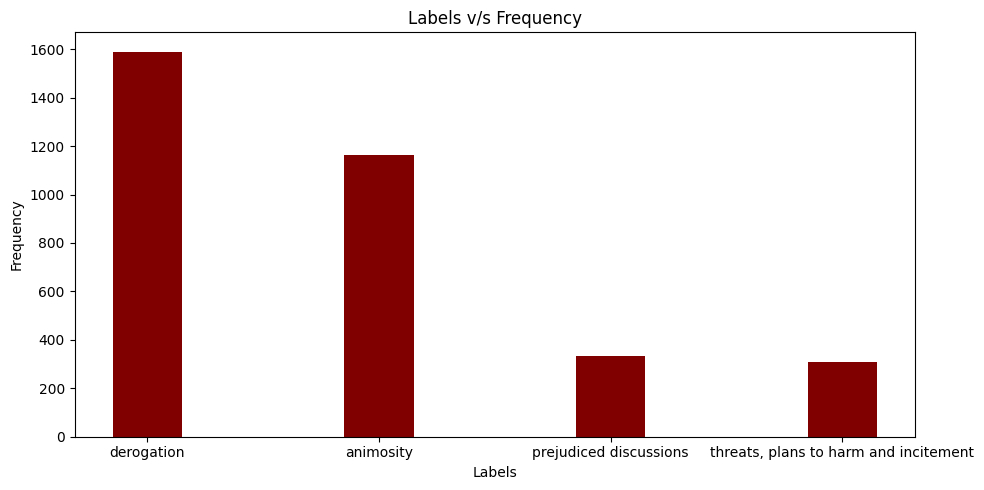

In [43]:
import matplotlib.pyplot as plt

freq=train_dfB['label_category'].value_counts().to_dict()
print(freq)

data = freq
types = ['derogation', 'animosity', 'prejudiced discussions', 'threats, plans to harm and incitement']
frequency = list(data.values())

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(types, frequency, color ='maroon',width = 0.3)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels v/s Frequency")
plt.tight_layout()
plt.show()

In [44]:
trainB, valB = train_test_split(train_dfB, test_size = 0.3, random_state = 2023, stratify = train_dfB.label_category)
valB, testB = train_test_split(valB, test_size = 0.5, random_state = 2023, stratify = valB.label_category)

In [45]:
label_map = {
    "1. threats, plans to harm and incitement": 0,
    "2. derogation": 1,
    "3. animosity": 2,
    "4. prejudiced discussions": 3
}

trainB["label_category"] = trainB["label_category"].map(label_map).tolist()
valB["label_category"] = valB["label_category"].map(label_map).tolist()
testB["label_category"] = testB["label_category"].map(label_map).tolist()

In [46]:
X_train_B = trainB["text"].tolist()
y_train_B = trainB["label_category"].tolist()

X_test_B = testB["text"].tolist()
y_test_B = testB["label_category"].tolist()

X_val_B = valB["text"].tolist()
y_val_B = valB["label_category"].tolist()

### Multi-class Ensemble

In [47]:
from sklearn.ensemble import VotingClassifier
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


# Load the trained ELECTRA model
num_categories = 4
deberta_multi_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
loaded_multi_deberta_model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base',num_labels=num_categories)
loaded_multi_deberta_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Masters thesis/debertaModelB.pth'))
loaded_multi_deberta_model.eval()

# Load the trained DeBERTa model
multi_distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
loaded_multi_distilbert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=num_categories)
loaded_multi_distilbert_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Masters thesis/distilbertModelB.pth'))
loaded_multi_distilbert_model.eval()

def ensemble_predict_multi(texts):
    with torch.no_grad():
        distilbert_input_ids = torch.tensor(multi_distilbert_tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=48)['input_ids'])
        distilbert_predictions = loaded_multi_distilbert_model(distilbert_input_ids).logits

        deberta_multi_input_ids = torch.tensor(multi_distilbert_tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=48)['input_ids'])
        deberta_multi_predictions = loaded_multi_deberta_model(deberta_multi_input_ids).logits

        ensemble_predictions = np.argmax((distilbert_predictions + deberta_multi_predictions) / 2, axis=1)

    return ensemble_predictions

# Test ensemble predictions
#test_texts = test["text"].tolist()
ensemble_predictions_taskB = ensemble_predict_multi(X_test_B)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
print(classification_report(y_test_B, ensemble_predictions_taskB))

              precision    recall  f1-score   support

           0       0.92      0.26      0.41        46
           1       0.50      0.95      0.65       239
           2       0.68      0.15      0.24       175
           3       0.00      0.00      0.00        50

    accuracy                           0.52       510
   macro avg       0.53      0.34      0.33       510
weighted avg       0.55      0.52      0.43       510



### Main Model Architecture

In [49]:
#Prediction Function
def predict_with_model(model, tokenizer, texts):
    with torch.no_grad():
        inputs_ids = torch.tensor(tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=48)['input_ids'])
        outputs = model(inputs_ids).logits
    return outputs

# Ensemble Function
def ensemble_predictions(logits1, logits2):
    return (logits1 + logits2) / 2

# Prediction Pipeline
def hierarchical_prediction(texts):
    # Binary Classification
    texts = [texts]
    electra_logits = predict_with_model(loaded_electra_model, electra_tokenizer, texts)
    deberta_logits = predict_with_model(loaded_deberta_model, deberta_tokenizer, texts)
    ensemble_bin_logits = ensemble_predictions(electra_logits, deberta_logits)
    ensemble_bin_probs = F.softmax(ensemble_bin_logits, dim=1)
    #print("ensemble_bin_probs --> ",ensemble_bin_probs)
    binary_predictions = (ensemble_bin_probs[:, 1] > 0.5).int()
    binary_prediction = binary_predictions[0].item()

    # If Non-Sexist, return
    if binary_prediction == 0:
        return "Non Sexist"

    # Multi-Class Classification for Sexist Comments
    distilbert_multi_logits = predict_with_model(loaded_multi_distilbert_model, multi_distilbert_tokenizer, texts)
    deberta_multi_logits = predict_with_model(loaded_multi_deberta_model, deberta_multi_tokenizer, texts)
    ensemble_multi_logits = ensemble_predictions(distilbert_multi_logits, deberta_multi_logits)
    multi_class_prediction = torch.argmax(ensemble_multi_logits, dim=1).item()

    categories = ["1. threats, plans to harm and incitement", "2. derogation",
                  "3. animosity","4. prejudiced discussions"]
    return f"Sexist ({categories[multi_class_prediction]})"

In [50]:
print(f"\n===== Explainable Detection of Online Sexism ======\n")
while True:
  try:
    print(f"Response : {hierarchical_prediction(input('Enter a sectence : '))}")
    print("")
  except KeyboardInterrupt:
    break
  except ValueError:
    print("Please enter a correct value - String")
  except Exception as e:
    print(f"Whoops ! Something went wrong : {e}")
    break


===== Explainable Detection of Online Sexism ======

Enter a sectence : Hi, Have a lovely day!
Response : Non Sexist

Enter a sectence : Until she divorce rapes him
Response : Non Sexist

Enter a sectence : She is ugly as fuck in both though looks like a tranny on the right
Response : Non Sexist

Enter a sectence : I voted on that one. Fuck those BLM pussys
Response : Sexist (3. animosity)

Enter a sectence : I will punch that pussy
Response : Sexist (1. threats, plans to harm and incitement)

